# Imports

In [1]:
#export
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'exp'))

import json
import yaml
import datetime
import collections
from pathlib import Path
from collections import OrderedDict

import numpy as np
import pandas as pd
from nb_base_exp import *#BaseExperiment, BaseProject, load_txt_log


In [2]:
import plotly.express as px
import shutil

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Code

In [4]:
#export
def load_log(path):
    columns = ['date','epoch','acc','val_acc']
    types = [str, np.int32, np.float32, np.float32]
    log_path = list(path.rglob('*/*/log.txt'))[0]

    _, logs = load_txt_log(path=log_path, types=types)

    df = pd.DataFrame(logs, columns=columns)
    df.dropna(inplace=True)
    df = df.astype(dict(zip(columns, types)))

    df['val_acc'].replace(-1., np.NaN, inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.set_index('epoch', inplace=True)
    timeDF=(pd.to_datetime(df['date'].str.strip(), format='%H:%M:%S'))
    del df['date']# = timeDF
    df['duration'] = timeDF - timeDF[0]
    return df

def load_yaml_cfg(path):
    params_path = list(path.rglob('*/*/train.yaml'))[0]
    with open(params_path, 'r') as f:
        d = yaml.safe_load(f)
    d = flatten(d)
    d = OrderedDict(sorted(d.items(), key=lambda x:x[0], reverse=False))
    return d

def load_json_cfg(path):
    params_path = list(path.rglob('*/*/params.json'))[0]
    with open(params_path, 'r') as f:
        d = json.load(f)
    d = flatten(d)
    d = OrderedDict(sorted(d.items(), key=lambda x:x[0], reverse=False))
    return d

def load_cfg(*args, **kwargs):
    return load_json_cfg(*args, **kwargs)

def check_valid(cpath):
    flag_files = set(['log.txt', 'params.json'])
    where_to_look = 'output'
    output = list(Path(cpath).rglob(where_to_look))
    files=[]
    if output:
        files = list(output[0].glob('*/*'))

    return flag_files.issubset(set([f.name for f in files]))



In [119]:
#export
class GenExperiment(BaseExperiment):
    def __init__(self,  path):
        super(GenExperiment, self).__init__(path, log_reader=load_log, cfg_reader=load_cfg)
        self.start_time = self.parse_name()

    def parse_name(self, prefix='run_'):
        date = self.name.strip(prefix)#.rstrip('.lock')
        start_time = datetime.datetime.strptime(date, '%Y_%b_%d_%H_%M_%S_%f')
        return start_time

    def total_time(self):
        return self.log_data['duration'][self.__len__()-1]
    
class GenProject(BaseProject):
    def __init__(self,  root):
        super(GenProject, self).__init__(root, valid_func=check_valid, Experiment=GenExperiment)
    
    def extend_base(self):
        dd = {}
        for run in self.exps:
            run_best = run.best(num=3, col='val_acc')
            #run_best_pct = 100 - int( 100 * (run.total_time() - dur) / run.total_time())
            d = {}
            d['start'] = run.start_time
            d['name'] = run.name
            d['tt'] = run.total_time()
            d['t2b'] = run_best['duration'].values[0]
            d['ba'] = round(run_best.mean()[['acc']].values[0],3)
            d['bva'] = round(run_best.mean()[['val_acc']].values[0],3)
            d['la'] = round(run.log_data['acc'][-10:].mean(),3)
            #d.update(**run.params)
            dd[run.name] = d
        #res_df = pd.DataFrame(results, columns=['Name','duration', 'LRM', 'best_acc', 'best_val', 'best_pct', *run.params.keys()])

        df = pd.DataFrame(dd).T
        df = pd.concat([df,self.base_table()], axis=1)
        df.set_index('start', drop=True, inplace=True)
#         for x in ['tt','t2b']:
#             df[x] = pd.DatetimeIndex(df[x]).strftime("%H:%M:%S")
            
        df['ba'] = df['ba'].astype(float)
        df['la'] = df['la'].astype(float)
        df['bva'] = df['bva'].astype(float)
        df = df.round(4)
        
        
        return df

In [120]:
root = Path('.')/'cycler_runs'
bp = GenProject(root)
df = bp.extend_base()

In [121]:
df.sort_index(ascending=False).head(9)#[['crossover_chance', 'bva']].values
#df.sort_values('bva', ascending=False).head(10)

,name,tt,t2b,ba,bva,la,combine_chance,crossover_chance,dec_f0,dec_f1,dec_f2,dec_f3,exp_power,generation_size,generations,mutate_chance,seed,subsample_size
start,,,,,,,,,,,,,,,,,,
2020-05-18 22:06:34.357490,run_2020_May_18_22_06_34_357490,00:04:15,00:04:15,0.545,0.541,0.540,0.5,0.7453,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 22:06:34.234891,run_2020_May_18_22_06_34_234891,00:04:13,00:04:13,0.545,0.536,0.537,0.5,0.7453,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 22:06:22.254283,run_2020_May_18_22_06_22_254283,00:04:27,00:04:27,0.557,0.550,0.558,0.5,0.7453,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 21:59:19.805000,run_2020_May_18_21_59_19_805000,00:06:59,00:06:59,0.556,0.570,0.563,0.5,0.7453,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 21:59:13.812901,run_2020_May_18_21_59_13_812901,00:07:00,00:07:00,0.552,0.573,0.562,0.5,0.7453,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 21:59:07.882861,run_2020_May_18_21_59_07_882861,00:06:57,00:06:57,0.547,0.571,0.550,0.5,0.7453,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 21:52:01.413865,run_2020_May_18_21_52_01_413865,00:06:58,00:06:58,0.594,0.585,0.589,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 21:51:55.378618,run_2020_May_18_21_51_55_378618,00:06:59,00:05:58,0.603,0.575,0.584,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 21:51:49.400567,run_2020_May_18_21_51_49_400567,00:07:02,00:07:02,0.580,0.581,0.548,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50


In [122]:
df['tt'].sum()

Timedelta('4 days 00:52:25')

In [117]:
df = df[df['ba']>.3]
df.shape

(514, 18)

In [113]:
# df = df[df['ba']<.3]
# df.shape
# names = df.sort_index()['name'][:30].values
# p = Path('./cycler_runs/')
# for name in names:
#     pi = p/name
#     shutil.rmtree(pi)

In [88]:
r = ((df['crossover_chance'] == 0.9900) & (df['generations']==200))
s = df[r]['bva']
s.mean(), s.std()

(0.5766190476190476, 0.005616726720040695)

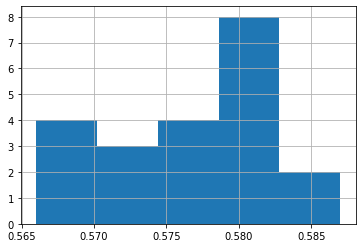

In [93]:
s.hist(bins=5)

In [90]:
t = df.sort_index(ascending=False).head(30)
t[['crossover_chance', 'bva']].values
t

,name,tt,t2b,ba,bva,la,combine_chance,crossover_chance,dec_f0,dec_f1,dec_f2,dec_f3,exp_power,generation_size,generations,mutate_chance,seed,subsample_size
start,,,,,,,,,,,,,,,,,,
2020-05-18 18:06:27.329057,run_2020_May_18_18_06_27_329057,00:04:56,00:04:56,0.582,0.568,0.573,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 17:59:07.094358,run_2020_May_18_17_59_07_094358,00:07:02,00:06:33,0.562,0.582,0.599,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 17:59:07.020744,run_2020_May_18_17_59_07_020744,00:07:00,00:06:23,0.601,0.584,0.582,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 17:59:06.983681,run_2020_May_18_17_59_06_983681,00:07:00,00:06:37,0.588,0.573,0.593,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 17:51:48.494611,run_2020_May_18_17_51_48_494611,00:06:59,00:06:30,0.590,0.580,0.574,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 17:51:48.446639,run_2020_May_18_17_51_48_446639,00:07:00,00:07:00,0.562,0.572,0.578,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 17:51:42.427193,run_2020_May_18_17_51_42_427193,00:07:04,00:07:04,0.583,0.579,0.578,0.5,0.9900,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 17:44:29.975177,run_2020_May_18_17_44_29_975177,00:06:58,00:06:58,0.553,0.566,0.558,0.5,0.6046,12,10,8,6,10,200,200,0.003,0,50
2020-05-18 17:44:29.906910,run_2020_May_18_17_44_29_906910,00:06:59,00:06:36,0.568,0.570,0.547,0.5,0.6640,12,10,8,6,10,200,200,0.003,0,50


In [94]:
k = 'bva'
tdf = df.sort_index(ascending=False)[:10]
fig = px.parallel_coordinates(tdf, color=k,
              dimensions=['combine_chance', 'crossover_chance', 'mutate_chance', 'exp_power',
                         #'dec_f0','dec_f1','dec_f2','dec_f3',
                          'bva'],
              color_continuous_scale=px.colors.diverging.Tealrose,
              range_color=[.53,df[k].max()],
              color_continuous_midpoint=.55)
fig.show()

# Exports

In [11]:
!python3 extra/n2s.py gen_exp.ipynb 

Converted gen_exp.ipynb to exp/nb_gen_exp.py
